# Your First GAN

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
    def get_gen(self):
        return self.gen

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

In [5]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True)
    )

In [6]:
class Discriminator(nn.Module):

    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)
    
    def get_disc(self):
        return self.disc

In [7]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

In [8]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [9]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

You should roughly expect to see this progression. On a GPU, this should take about 15 seconds per 500 steps, on average, while on CPU it will take roughly 1.5 minutes:
![MNIST Digits](MNIST_Progression.png)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.3880912394523623, discriminator loss: 0.4192596367597577


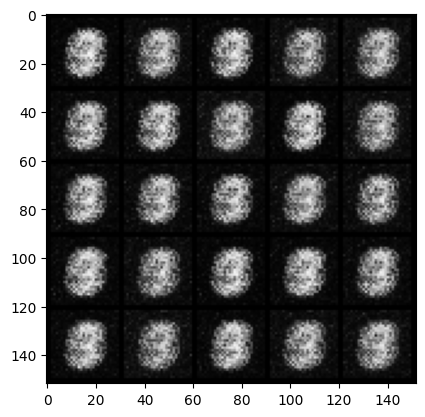

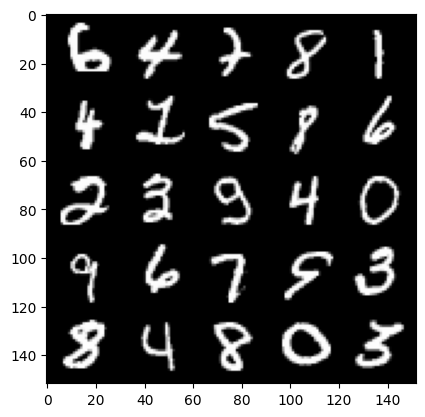

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.668954803466795, discriminator loss: 0.3002848706543445


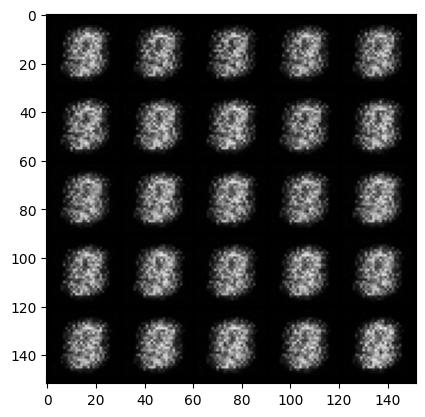

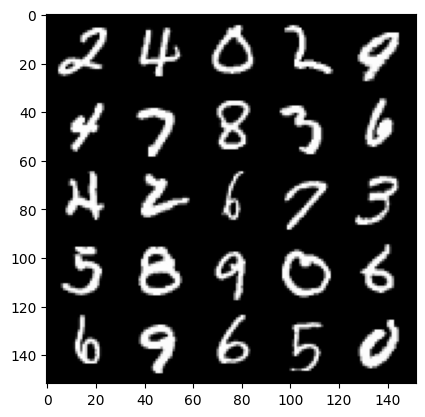

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.9593834037780749, discriminator loss: 0.1741470115184784


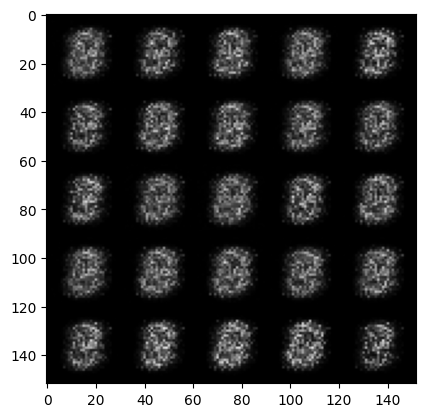

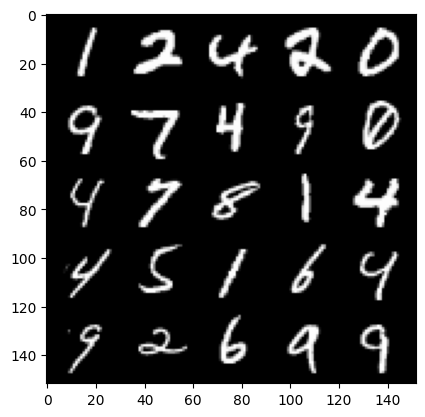

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.7624623236656196, discriminator loss: 0.19557266536355022


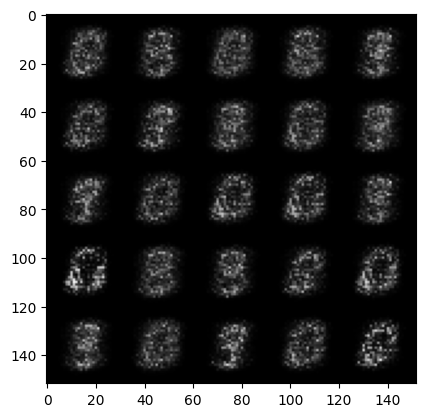

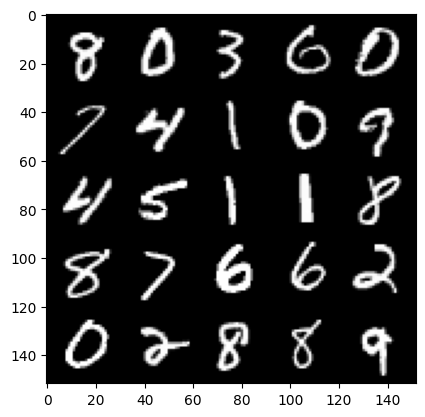

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.7255586135387428, discriminator loss: 0.19514360681176182


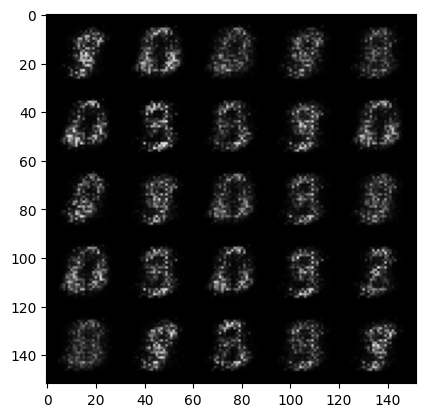

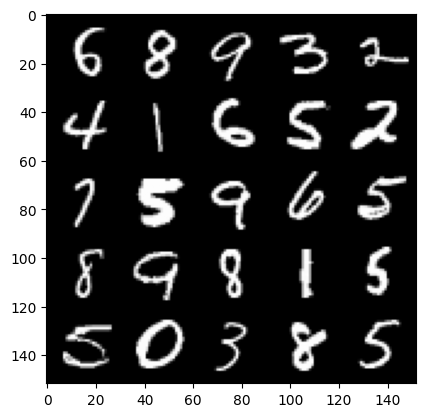

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.0244855573177345, discriminator loss: 0.15110075916349874


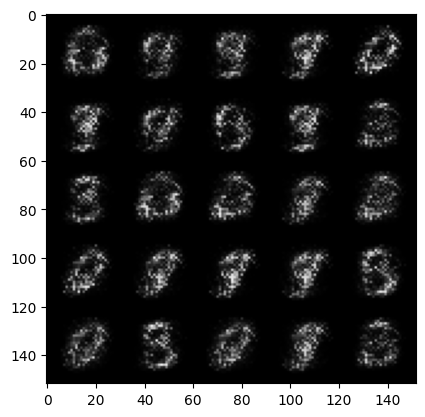

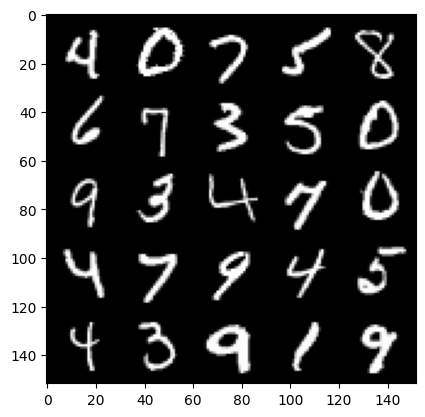

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.4024260683059695, discriminator loss: 0.12577036376297465


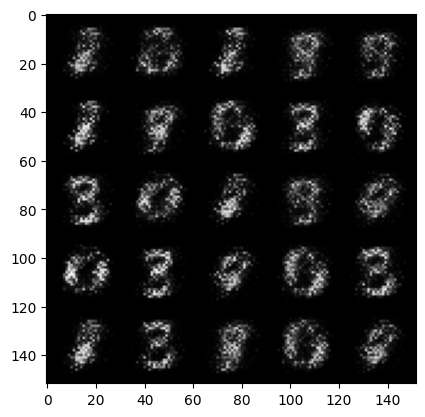

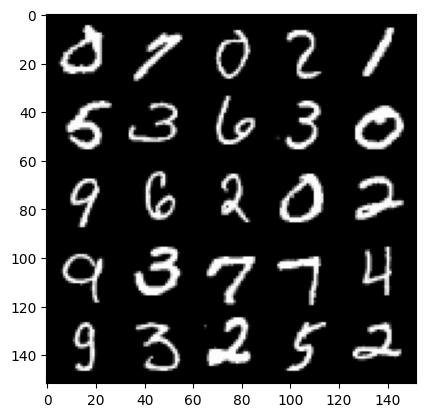

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.7107601509094246, discriminator loss: 0.12439144942164417


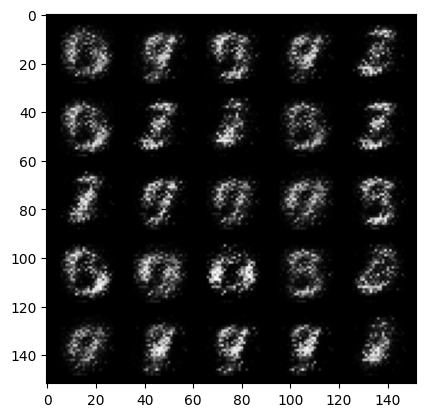

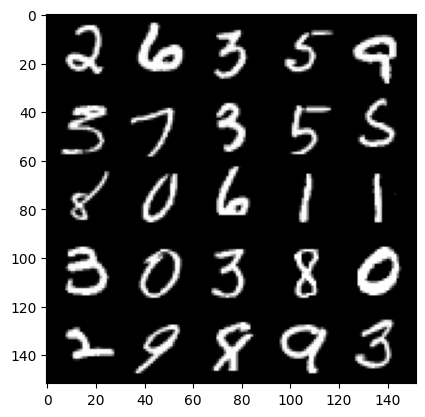

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 3.189953213214876, discriminator loss: 0.09954547509551043


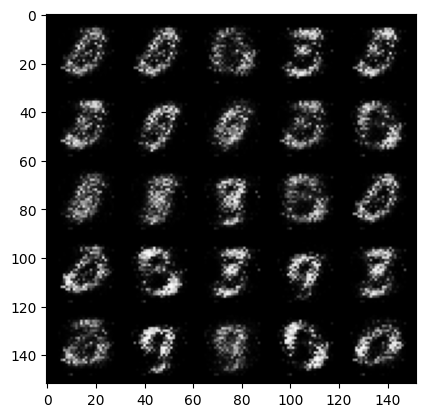

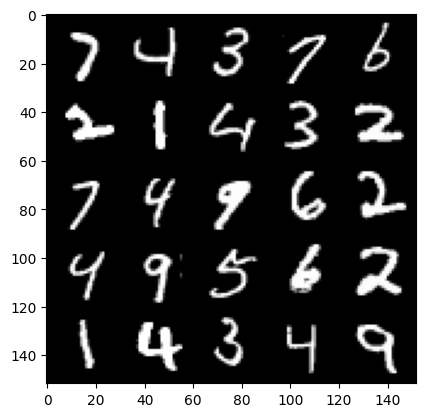

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.4630452508926397, discriminator loss: 0.08027609245479098


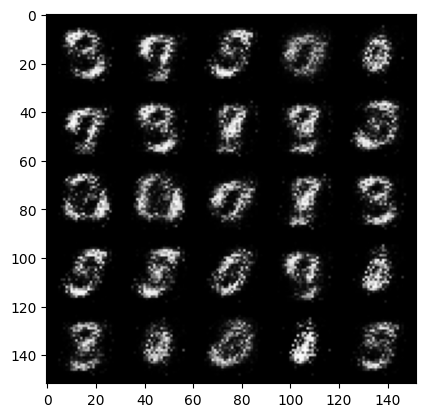

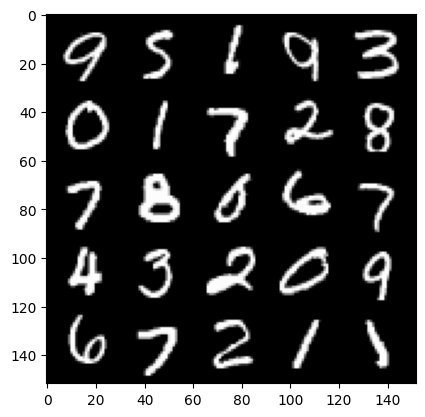

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.725527339458466, discriminator loss: 0.08046752046048647


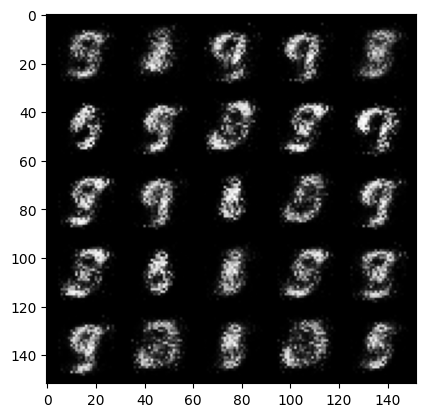

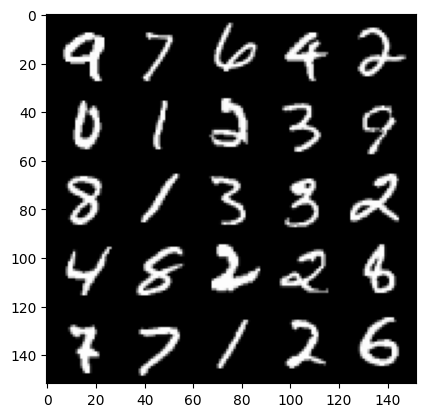

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.7611437797546365, discriminator loss: 0.07743679928779604


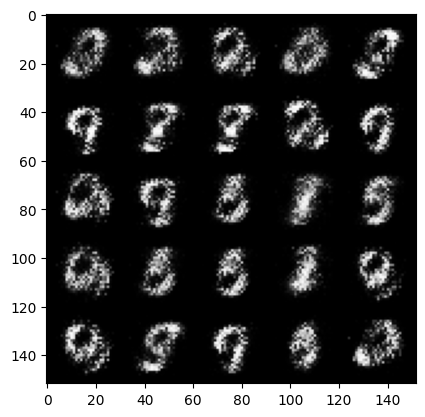

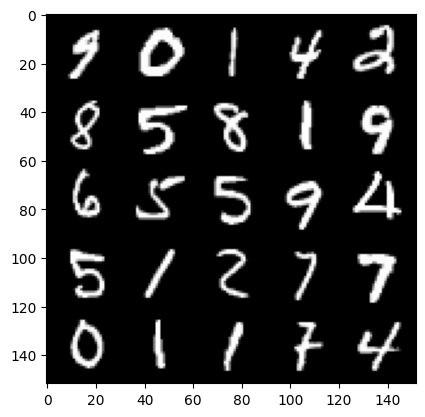

In [10]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)

        disc_opt.step()

        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()


        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()


        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
